## 代码测试 notebook

构建测试环境，使能够索引模块路径

In [32]:
import os
import sys
 
cur_dir = os.getcwd()
pkg_rootdir = os.path.dirname(cur_dir)
# pkg_rootdir = os.path.dirname(os.path.dirname(cur_dir))
print(pkg_rootdir)
if pkg_rootdir not in sys.path:
    sys.path.append(pkg_rootdir)

/home/brhu/WorkStation/Programming/Python/detr-s


### 测试 backbone类

In [33]:
# test code for models.backbone
import torch
from models.backbone import Backbone

name = 'resnet18'  # Example backbone name
train_backbone = True  # Example train_backbone value
return_interm_layers = True  # Example return_interm_layers value
dilation = False  # Example dilation value

backbone_instance = Backbone(name, train_backbone, return_interm_layers, dilation)
# 打印模型结构信息
print(backbone_instance)

# torch.save(backbone_instance.state_dict(), 'backbone.pth')

Backbone(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
      )
    )
    (layer2): Sequential(
   

### 测试位置编码类

torch.Size([3, 256, 25, 25])


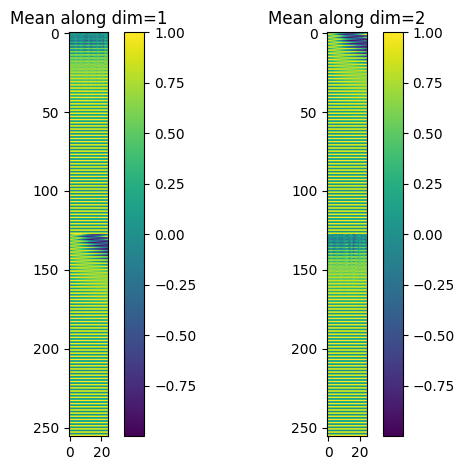

In [69]:
from models.pos_encodeing import PositionEmbeddingSine
import matplotlib.pyplot as plt
from util.misc import NestedTensor

# 创建一个示例输入
tensor = torch.randn(3, 25, 25)
# 创建掩码
mask_shape = (3, 25, 25)
mask = torch.rand(mask_shape) > 0.5
# mask = torch.rand(3, 25, 25, dtype=torch.bool)
tensor_list = NestedTensor(tensor, mask)

# 实例化类
pos_embedding = PositionEmbeddingSine(num_pos_feats=128, normalize=True, scale=None)

# 调用 forward 方法计算位置编码
output = pos_embedding(tensor_list)

print(output.shape)

# 可视化位置编码结果
# plt.imshow(output[0].mean(dim=0).detach().numpy(), cmap='hot')
# plt.colorbar()
# plt.show()

fig, axs = plt.subplots(1, 2)

# 在第一个子图中绘制图像1
im1 = axs[0].imshow(output[0].mean(dim=1).detach().numpy(), cmap='viridis')
axs[0].set_title('Mean along dim=1')
fig.colorbar(im1, ax=axs[0])

# 在第二个子图中绘制图像2
im2 = axs[1].imshow(output[0].mean(dim=2).detach().numpy(), cmap='viridis')
axs[1].set_title('Mean along dim=2')
fig.colorbar(im2, ax=axs[1])

# 调整子图之间的距离
fig.tight_layout()

# 显示图形
plt.show()